In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from scipy import interpolate
import matplotlib.pylab as plt
import datetime as dt
from scipy.optimize import least_squares

In [2]:
#set dataframe
rate_df = pd.read_csv("discount.csv")
call_df = pd.read_csv("goog_call.csv")
put_df = pd.read_csv("goog_put.csv")
call_df["mid_price"]=(call_df["best_bid"]+call_df["best_offer"])/2
put_df["mid_price"]=(put_df["best_bid"]+put_df["best_offer"])/2
mkt_df=pd.concat([put_df,call_df])
mkt_df.head()

,date,expiry,strike,best_bid,best_offer,mid_price
0,20130830,20150117,320,0.90,2.00,1.450
1,20130830,20150117,340,0.15,2.30,1.225
2,20130830,20150117,350,0.80,2.45,1.625
3,20130830,20150117,360,0.60,2.65,1.625
4,20130830,20150117,370,0.65,2.85,1.750


In [3]:
#interpolation
x = rate_df["Day"]
y = rate_df["Rate (%)"]
interp =interpolate.interp1d(x,y)

In [4]:
#Parameters
today = dt.date(2013, 8, 30)
expiry = dt.date(2015, 1, 17)
T = (expiry-today).days/365.0
S = 846.9
r = interp(T*365)/100
F = S*np.exp(r*T)

### ATM (AT-THE-MONEY) Implied Volatility


In [5]:
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S,K,r,sigma,T):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
def impliedCallVolatility(S, K, r, price, T):
    return brentq(lambda x: price -BlackScholesCall(S, K, r, x, T),1e-6, 1)

def impliedPutVolatility(S, K, r, price, T):
    return brentq(lambda x: price -BlackScholesPut(S, K, r, x, T),1e-6, 1)

using the mid-price to find ATM at where the strike price(K=850) is closest to the forward price(F=851.7)

In [6]:
ATMvolCall=impliedCallVolatility(S,850,r,101.4,T)
ATMvolPut=impliedPutVolatility(S,850,r,102.9,T)
ATMvol=float((ATMvolCall+ATMvolPut)/2)
print(ATMvol)

0.25827414878228977


#### Now we calculate market, norml, lognormal  and Displaced-diffusion(with different beta) implied volatilities.

In [7]:
#First we define all the models we need to use:
#Displaced-Diffusion Model
def DisplacedDiffusionCall(S,K,r,sigma,T,beta):
    F0 = (S*np.exp(r*T))
    d1 = (np.log(F0 / (beta * (K + (1 - beta) / beta * F0))) + 0.5 * T * (beta * sigma) ** 2) / (
                beta * sigma * np.sqrt(T))
    d2 = d1 - (sigma * beta) * np.sqrt(T)
    return np.exp(-r * T) * ((F0 / beta) * norm.cdf(d1) - (K + (1 - beta) / beta * F0) * norm.cdf(d2))

def DisplacedDiffusionPut(S,K,r,sigma,T,beta):
    F0 = (S*np.exp(r*T))
    d1 = (np.log(F0 / (beta * (K + (1 - beta) / beta * F0))) + 0.5 * T * (beta * sigma) ** 2) / (
                beta * sigma * np.sqrt(T))
    d2 = d1 - (sigma * beta) * np.sqrt(T)
    return np.exp(-r * T) * ((K + ((1 - beta) / beta) * F0) * norm.cdf(-d2) - (F0 / beta) * norm.cdf(-d1))

#Bachelier Model
def BachelierCall(S,K,sigma,T):
    d = (S-K)/(S*sigma*np.sqrt(T))
    return (S-K)*norm.cdf(d)+S*sigma*np.sqrt(T)*norm.pdf(d)
    
def BachelierPut(S,K,sigma,T):
    d = (S-K)/(S*sigma*np.sqrt(T))
    return (K-S)*norm.cdf(-d)+S*sigma*np.sqrt(T)*norm.pdf(-d)

In [8]:
#Now we do the calculation:
summary = []
for i in call_df.index:
    K = call_df.loc[i]["strike"]
    if K >= 850:
        Vol_market = impliedCallVolatility(S, K, r, call_df["mid_price"][i], T)
        
        Vol_normal=impliedCallVolatility(S, K, r, BachelierCall(S, K, ATMvol, T), T)
      
        Vol_lognormal = impliedCallVolatility(S, K, r,BlackScholesCall(S, K, r, ATMvol, T), T)

        Vol_DD1 = impliedCallVolatility(S, K, r, DisplacedDiffusionCall(S, K, r, ATMvol, T, 0.2), T)

        Vol_DD2 = impliedCallVolatility(S, K, r, DisplacedDiffusionCall(S, K, r, ATMvol, T, 0.4), T)

        Vol_DD3 = impliedCallVolatility(S, K, r, DisplacedDiffusionCall(S, K, r, ATMvol, T, 0.6), T)

        Vol_DD4 = impliedCallVolatility(S, K, r, DisplacedDiffusionCall(S, K, r, ATMvol, T, 0.8), T)
        
    if K <= 850:
        Vol_market = impliedPutVolatility(S, K, r, put_df["mid_price"][i], T)
 
        Vol_normal= impliedPutVolatility(S, K, r, BachelierPut(S, K, ATMvol, T), T)   

        Vol_lognormal = impliedPutVolatility(S, K, r, BlackScholesPut(S, K, r, ATMvol, T), T) 

        Vol_DD1 = impliedPutVolatility(S, K, r,  DisplacedDiffusionPut(S, K, r, ATMvol, T, 0.2), T)

        Vol_DD2 = impliedPutVolatility(S, K, r,  DisplacedDiffusionPut(S, K, r, ATMvol, T, 0.4), T)

        Vol_DD3 = impliedPutVolatility(S, K, r,  DisplacedDiffusionPut(S, K, r, ATMvol, T, 0.6), T)

        Vol_DD4 = impliedPutVolatility(S, K, r,  DisplacedDiffusionPut(S, K, r, ATMvol, T, 0.8), T)


    summary.append([K, Vol_market, Vol_normal, Vol_lognormal, Vol_DD1, Vol_DD2, Vol_DD3, Vol_DD4])

df_combine = pd.DataFrame(summary, columns=["strike","impliedvol_market","impliedvol_normal","impliedvol_lognormal", "impliedvol_DD1","impliedvol_DD2","impliedvol_DD3","impliedvol_DD4"])
df_combine.head()

,strike,impliedvol_market,impliedvol_normal,impliedvol_lognormal,impliedvol_DD1,impliedvol_DD2,impliedvol_DD3,impliedvol_DD4
0,320.0,0.393102,0.410059,0.258274,0.382252,0.354314,0.324730,0.293003
1,340.0,0.361520,0.399618,0.258274,0.373432,0.347321,0.319742,0.290289
2,350.0,0.365782,0.394686,0.258274,0.369270,0.344029,0.317402,0.289021
3,360.0,0.355104,0.389931,0.258274,0.365260,0.340861,0.315155,0.287808
4,370.0,0.348660,0.385342,0.258274,0.361392,0.337810,0.312995,0.286645


### Displaced-Diffusion Calibration

In [9]:
def ddcalibration(x, strikes, vols, F, T, r):
    err = 0.0
    for i,vol in enumerate(vols):
        if strikes[i] >= 850:
             err += (vol - impliedCallVolatility(S, strikes[i], r, DisplacedDiffusionCall(F, strikes[i], r, ATMvol, T, x), T))**2
        if strikes[i] <= 850:
             err += (vol - impliedPutVolatility(S, strikes[i], r, DisplacedDiffusionPut(F, strikes[i], r, ATMvol, T, x), T))**2
                
    return err

DDinitialGuess = 0.2
res_DD = least_squares(lambda x: ddcalibration(x,
                                              df_combine["strike"].values,
                                              df_combine["impliedvol_market"].values,
                                              F,T,r), 
                                              DDinitialGuess)
DDbeta = res_DD.x[0]

#generating a new Displaced-Diffusion Model implied volatility after calibration
summary_dd = []
for i in df_combine.index:
    K = df_combine.loc[i]["strike"]
    if K > 850:        
        impliedvol_DD = impliedCallVolatility(S, K, r, DisplacedDiffusionCall(S, K, r, ATMvol, T, DDbeta), T) 
        
    if K <= 850:        
        impliedvol_DD = impliedPutVolatility(S, K, r, DisplacedDiffusionPut(S, K, r, ATMvol, T, DDbeta), T)
        
    summary_dd.append([impliedvol_DD])

df_combine["impliedvol_DD"] = np.array(summary_dd)
df_combine.head()

,strike,impliedvol_market,impliedvol_normal,impliedvol_lognormal,impliedvol_DD1,impliedvol_DD2,impliedvol_DD3,impliedvol_DD4,impliedvol_DD
0,320.0,0.393102,0.410059,0.258274,0.382252,0.354314,0.324730,0.293003,0.364307
1,340.0,0.361520,0.399618,0.258274,0.373432,0.347321,0.319742,0.290289,0.356655
2,350.0,0.365782,0.394686,0.258274,0.369270,0.344029,0.317402,0.289021,0.353048
3,360.0,0.355104,0.389931,0.258274,0.365260,0.340861,0.315155,0.287808,0.349577
4,370.0,0.348660,0.385342,0.258274,0.361392,0.337810,0.312995,0.286645,0.346232


### SABR Model Calibration

In [10]:
#Define SABR Model
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [11]:
#SABR Calibration
SARBbeta = 0.8
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T, x[0], SARBbeta, x[1], x[2]))**2
    return err

SARBinitialGuess = [0.02, 0.2, 0.1]
res_SARB = least_squares(lambda x: sabrcalibration(x,df_combine["strike"].values,df_combine["impliedvol_market"].values,F,T),SARBinitialGuess)

alpha = res_SARB.x[0]
rho = res_SARB.x[1]
nu = res_SARB.x[2]

In [12]:
alpha

0.9907772780171966

In [13]:
rho

-0.28514715549366737

In [14]:
nu

0.3522271349016911

### Implied Volatility for SABR with different Rho and Nu

In [15]:
SARBbeta = 0.8

rho1,rho2,rho3 = -0.5,0.0,0.5

nu1,nu2,nu3 = 0.1,0.3,0.5

In [16]:
summary2 = []
for i in df_combine.index:
    K = df_combine.loc[i]["strike"]
    if K > 850:
        Vol_market = impliedCallVolatility(S, K, r, call_df['mid_price'][i], T)

        Vol_lognormal = impliedCallVolatility(S, K, r,BlackScholesCall(S, K, r, ATMvol, T), T)
    if K <= 850:
        Vol_market = impliedPutVolatility(S, K, r, put_df['mid_price'][i], T)

        Vol_lognormal =impliedPutVolatility(S, K, r, BlackScholesPut(S, K, r, ATMvol, T), T) 


    Vol_SABR = SABR(F, K, T, alpha, SARBbeta, rho, nu)

    Vol_rho1 = SABR(F, K, T, alpha, SARBbeta, rho1, nu)
    Vol_rho2 = SABR(F, K, T, alpha, SARBbeta, rho2, nu)
    Vol_rho3 = SABR(F, K, T, alpha, SARBbeta, rho3, nu)

    Vol_nu1 = SABR(F, K, T, alpha, SARBbeta, rho, nu1)
    Vol_nu2 = SABR(F, K, T, alpha, SARBbeta, rho, nu2)
    Vol_nu3 = SABR(F, K, T, alpha, SARBbeta, rho, nu3)

    summary2.append([K,Vol_market,Vol_lognormal,Vol_SABR, Vol_rho1, Vol_rho2,Vol_rho3,Vol_nu1, Vol_nu2,Vol_nu3])

df_combine2 = pd.DataFrame(summary2, columns=["strike", "impliedvol_market","impliedvol_lognormal","impliedvol_SABR", "impliedvol_rho1", "impliedvol_rho2","impliedvol_rho3", "impliedvol_nu1", "impliedvol_nu2","impliedvol_nu3"])
df_combine2.head()

,strike,impliedvol_market,impliedvol_lognormal,impliedvol_SABR,impliedvol_rho1,impliedvol_rho2,impliedvol_rho3,impliedvol_nu1,impliedvol_nu2,impliedvol_nu3
0,320.0,0.393102,0.258274,0.368805,0.386587,0.340208,0.270207,0.300857,0.353244,0.415168
1,340.0,0.361520,0.258274,0.361070,0.378170,0.333553,0.266172,0.297892,0.346523,0.404618
2,350.0,0.365782,0.258274,0.357384,0.374145,0.330405,0.264342,0.296483,0.343324,0.399575
3,360.0,0.355104,0.258274,0.353810,0.370233,0.327369,0.262631,0.295120,0.340225,0.394676
4,370.0,0.348660,0.258274,0.350344,0.366428,0.324440,0.261034,0.293799,0.337222,0.389914


### Plot the implied volatility smile of market, Displaced-Diffusion Model and SABR Model

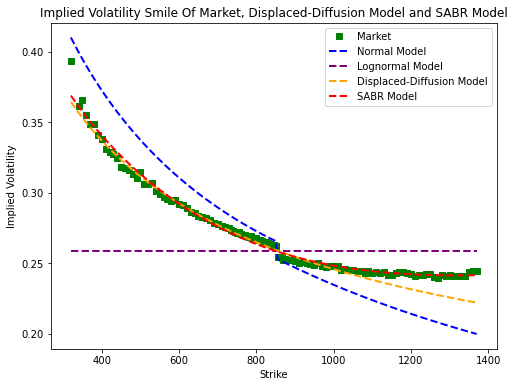

In [17]:
# plot of market data and calibrated Displaced-Diffusion Model
plt.figure(figsize=(8, 6))
plt.plot(df_combine["strike"],df_combine["impliedvol_market"],"gs",label="Market")
plt.plot(df_combine["strike"],df_combine["impliedvol_normal"],"b--",linewidth=2,label="Normal Model")
plt.plot(df_combine["strike"],df_combine["impliedvol_lognormal"],"purple",linestyle="--",linewidth=2,label="Lognormal Model")
plt.plot(df_combine["strike"],df_combine["impliedvol_DD"],"orange",linestyle="--",linewidth=2,label="Displaced-Diffusion Model")
#plot of calibrated SABR Model
plt.plot(df_combine2["strike"],df_combine2["impliedvol_SABR"],"red",linestyle="--",linewidth=2,label="SABR Model")

plt.title("Implied Volatility Smile Of Market, Displaced-Diffusion Model and SABR Model")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.legend(loc="upper right")
plt.show()

### Plot the implied volatility smile of Displaced-Diffusion Model with varied beta(β)

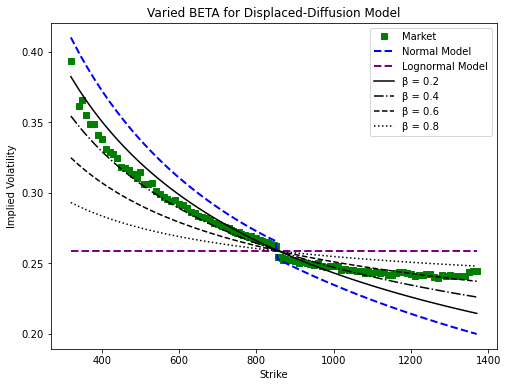

In [18]:
# plot of market data
plt.figure(figsize=(8, 6))
plt.plot(df_combine["strike"],df_combine["impliedvol_market"],"gs",label="Market")
plt.plot(df_combine["strike"],df_combine["impliedvol_normal"],"blue",linestyle="--",linewidth=2,label="Normal Model")
plt.plot(df_combine["strike"],df_combine["impliedvol_lognormal"],"purple",linestyle="--",linewidth=2,label="Lognormal Model")
#plot Displaced-Diffusion Model with different beta
plt.plot(df_combine["strike"],df_combine["impliedvol_DD1"],"k-",label="β = 0.2")
plt.plot(df_combine["strike"],df_combine["impliedvol_DD2"],"k-.",label="β = 0.4")
plt.plot(df_combine["strike"],df_combine["impliedvol_DD3"],"k--",label="β = 0.6")
plt.plot(df_combine["strike"],df_combine["impliedvol_DD4"],"k:" ,label="β = 0.8")

plt.title("Varied BETA for Displaced-Diffusion Model")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.legend(loc="upper right")
plt.show()

### Plot the implied volatility smile of SABR Model with varied rho(ρ)

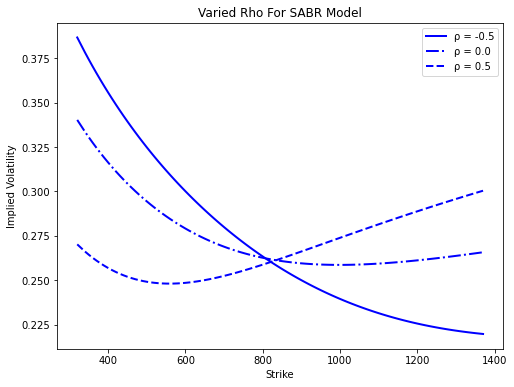

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(df_combine2["strike"],df_combine2["impliedvol_rho1"],"b-", linewidth=2,label="ρ = -0.5")
plt.plot(df_combine2["strike"],df_combine2["impliedvol_rho2"],"b-.", linewidth=2,label="ρ = 0.0")
plt.plot(df_combine2["strike"],df_combine2["impliedvol_rho3"],"b--", linewidth=2,label="ρ = 0.5")

plt.title("Varied Rho For SABR Model")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.legend(loc="upper right")
plt.show()

### Plot the implied volatility smile of SABR Model with varied nu(ν)

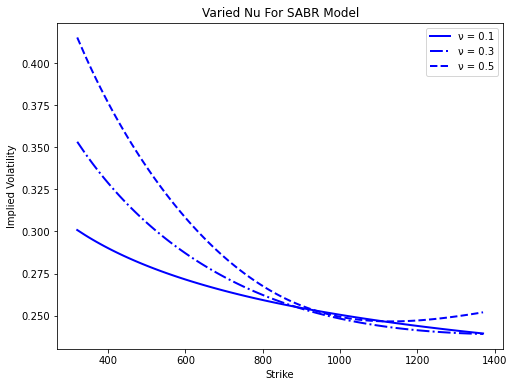

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(df_combine2["strike"],df_combine2["impliedvol_nu1"],"b-", linewidth=2,label="ν = 0.1")
plt.plot(df_combine2["strike"],df_combine2["impliedvol_nu2"],"b-.", linewidth=2,label="ν = 0.3")
plt.plot(df_combine2["strike"],df_combine2["impliedvol_nu3"],"b--", linewidth=2,label="ν = 0.5")

plt.title("Varied Nu For SABR Model")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.legend(loc="upper right")
plt.show()